Due to recent economic uncertainty, I became interested in understanding how the real estate market has evolved—specifically in Denmark, a country known for its high quality of life and strong housing demand. In this project, I analyze Danish housing price data to explore key trends and patterns.

We aim to answer the following questions:

1. What is the average house price in Denmark?
2. Has the average house price in Denmark shown an upward trend in recent years?
3. Are there specific regions or "hotspots" in Denmark with significantly higher average house prices?
5. Which factors have the most significant impact on Danish house prices?


Start with the process of data loading and cleaning:

In [1]:
# Load packages
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


NotFoundError: dlopen(/Users/fangyanxu/anaconda3/envs/PIC16B/lib/python3.11/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): Symbol not found: __ZN10tensorflow16TensorShapeProtoC1ERKS0_
  Referenced from: <10B7FC95-0B10-3E4E-84D0-79A2D52E4D78> /Users/fangyanxu/anaconda3/envs/PIC16B/lib/python3.11/site-packages/tensorflow-plugins/libmetal_plugin.dylib
  Expected in:     <E232C875-F50C-32BA-8200-00E4EE27C31B> /Users/fangyanxu/anaconda3/envs/PIC16B/lib/python3.11/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so

In [ ]:
# Load dataset
raw_data = pd.read_csv("DKHousingPricesSample100k.csv")
raw_data.head()

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
0,2024-10-24,2024Q4,16,Villa,regular_sale,1997,6500000,-3.0,5,142.0,45774.650,Spættevej 16,2680,Solrød Strand,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
1,2024-10-24,2024Q4,13,Apartment,regular_sale,1885,3400000,0.0,2,46.0,73913.050,"Jakob Dannefærds Vej 10B, 4. th",1973,Frederiksberg C,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
2,2024-10-23,2024Q4,60,Villa,regular_sale,1949,4550000,-4.0,4,112.0,40625.000,Vestre Plantagevej 3,2680,Solrød Strand,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
3,2024-10-23,2024Q4,29,Villa,regular_sale,2001,1630000,-12.0,4,186.0,8763.440,Toftebjerg 3,4400,Kalundborg,Other islands,Zealand,3.1,NaN,NaN
4,2024-10-22,2024Q4,92,Apartment,regular_sale,1965,1975000,-10.0,3,82.0,24085.365,"Ryttergårdsvej 20, 1. 113",3520,Farum,North Zealand,Zealand,3.1,NaN,NaN


In [ ]:
# Quick Overview
raw_data.columns

Index(['date', 'quarter', 'house_id', 'house_type', 'sales_type', 'year_build',
       'purchase_price', '%_change_between_offer_and_purchase', 'no_rooms',
       'sqm', 'sqm_price', 'address', 'zip_code', 'city', 'area', 'region',
       'nom_interest_rate%', 'dk_ann_infl_rate%',
       'yield_on_mortgage_credit_bonds%'],
      dtype='object')

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   date                                 100000 non-null  object 
 1   quarter                              100000 non-null  object 
 2   house_id                             100000 non-null  int64  
 3   house_type                           100000 non-null  object 
 4   sales_type                           100000 non-null  object 
 5   year_build                           100000 non-null  int64  
 6   purchase_price                       100000 non-null  int64  
 7   %_change_between_offer_and_purchase  100000 non-null  float64
 8   no_rooms                             100000 non-null  int64  
 9   sqm                                  100000 non-null  float64
 10  sqm_price                            100000 non-null  float64
 11  address       

The dataset includes housing price information in Denmark across multiple years. This allows us to explore various trends and pattern in the Danish real estate market. We can start our data analysis by identifying the potential key factors that influence house prices in Denmark. Based on the avaiable features, we may conclude: 
1. Type of housing
2. The year of construction
3. Number of rooms
4. Living area in square meters
5. Geographic region

This basic exploration will help us understand which features have the most significant impact on houseing price and how the market has evolved over time. So, we begin some columns manipulation

In [ ]:
# Pick the most informative factor. 
# Combine the column 'region' and 'area' as a 'location' column
raw_data["location"] = raw_data["region"] + "-" + raw_data["area"]

# Check the correlation coefficient between 'rooms' and 'sqm'
raw_data[["no_rooms", "sqm"]].corr()



,no_rooms,sqm
no_rooms,1.000000,0.770604
sqm,0.770604,1.000000


We got a strong positive correlation, so we can create a new feature: room density 

In [ ]:
raw_data['room_density'] = raw_data['no_rooms'] / raw_data['sqm']

# Derive price per sqm
raw_data['sqm_price'] = raw_data['purchase_price'] / raw_data['sqm']

# Compute house age
raw_data['date'] = pd.to_datetime(raw_data['date'], errors='coerce')
raw_data['house_age'] = raw_data['date'].dt.year - raw_data['year_build']



Data Cleaning: Check and remove missing values

In [ ]:
# Handling missing values
raw_data.isnull().sum()

date                                    0
quarter                                 0
house_id                                0
house_type                              0
sales_type                              0
year_build                              0
purchase_price                          0
%_change_between_offer_and_purchase     0
no_rooms                                0
sqm                                     0
sqm_price                               0
address                                 0
zip_code                                0
city                                   11
area                                    0
region                                  0
nom_interest_rate%                      0
dk_ann_infl_rate%                      77
yield_on_mortgage_credit_bonds%        77
location                                0
room_density                            0
house_age                               0
dtype: int64

As we observed from above, there are missing values for columns: 'city', 'dk_ann_infl_rate%' and 'yield_on_mortgage_credit_bonds% '. For those missing data that are useful for the task we try to fill it. Firstly, check zip code of missing cities and fill it out the cities by its zip cood. For missing value of columns 'dk_ann_infl_rate%' and 'yield_on_mortgage_credit_bonds% ', we try to fill it with its mean value.

In [ ]:
# Find the most common 'city' through zip code
city_groupby_zip = raw_data.groupby('zip_code')['city'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')

# Fill the empty city by their zip code
raw_data['city'] = raw_data.apply(
    lambda row: city_groupby_zip[row['zip_code']] if pd.isnull(row['city']) else row['city'], axis=1
)

# Impute missing value of columns 'dk_ann_infl_rate%' and 'yield_on_mortgage_credit_bonds% ' with their mean
raw_data['dk_ann_infl_rate%'].fillna(raw_data['dk_ann_infl_rate%'].mean(), inplace=True)
raw_data['yield_on_mortgage_credit_bonds%'].fillna(raw_data['yield_on_mortgage_credit_bonds%'].mean(), inplace=True)

# Verify if there are any remaining missing values
print("Remaining missing values after imputation:")
print(raw_data.isnull().sum())

Remaining missing values after imputation:
date                                   0
quarter                                0
house_id                               0
house_type                             0
sales_type                             0
year_build                             0
purchase_price                         0
%_change_between_offer_and_purchase    0
no_rooms                               0
sqm                                    0
sqm_price                              0
address                                0
zip_code                               0
city                                   0
area                                   0
region                                 0
nom_interest_rate%                     0
dk_ann_infl_rate%                      0
yield_on_mortgage_credit_bonds%        0
location                               0
room_density                           0
house_age                              0
dtype: int64


Check house price distribution

count    1.000000e+05
mean     1.925992e+06
std      1.777832e+06
min      2.502000e+05
25%      8.000000e+05
50%      1.400000e+06
75%      2.450000e+06
max      4.595500e+07
Name: purchase_price, dtype: float64


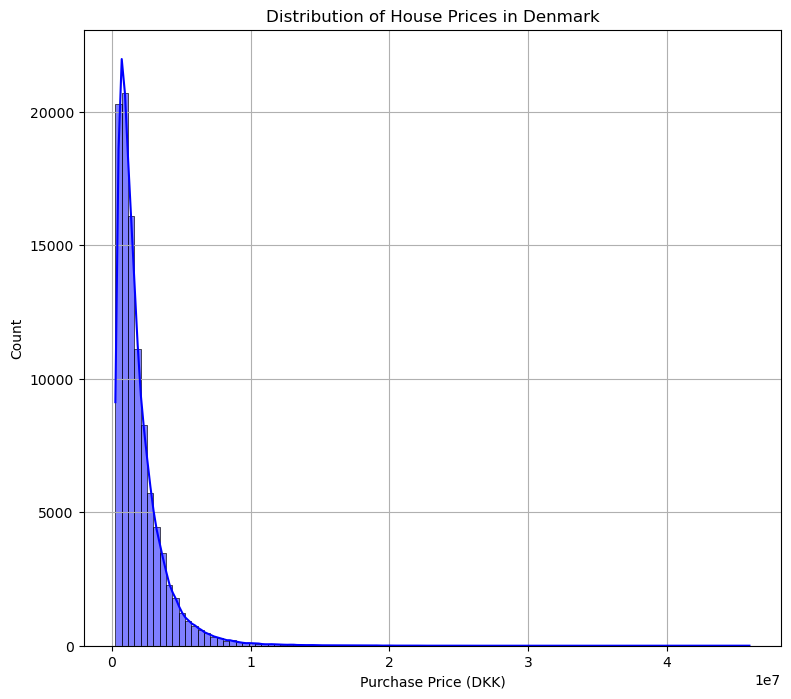

In [ ]:
# Data after preprocessing
data = raw_data

# The summary statistics for house price
print(data['purchase_price'].describe())

# Plot house price distribution
plt.figure(figsize=(9, 8))
sns.histplot(data['purchase_price'], color = 'blue', bins = 100, kde = True)
plt.title('Distribution of House Prices in Denmark')
plt.xlabel('Purchase Price (DKK)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

We obtain a heavily right-skewed price distribution plot.
Let's try to anser some questions:
What is the average house price in Denmark?

In [ ]:
avg_price = data['purchase_price'].mean()
print(f"Average hourse price in Denmark: {avg_price:.2f} DKK")

Average hourse price in Denmark: 1925992.20 DKK


Compare average house price by region:

In [ ]:
avg_by_region = data.groupby('region')['purchase_price'].mean().sort_values(ascending = False)
print(avg_by_region)

region
Zealand          2.389680e+06
Jutland          1.631618e+06
Fyn & islands    1.610287e+06
Bornholm         1.168617e+06
Name: purchase_price, dtype: float64


What is the trend of average house price in Denmark in recent year?

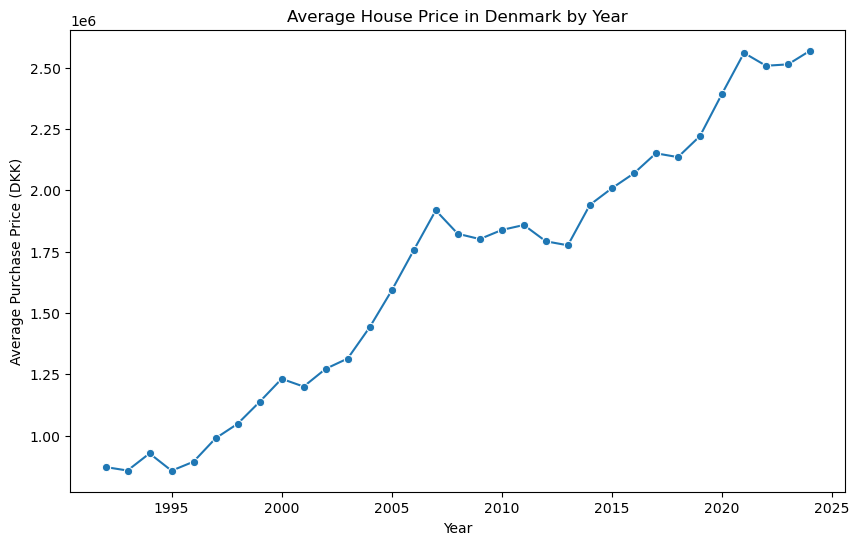

In [ ]:
# Extract year
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['year'] = data['date'].dt.year

# Group by year and compute the average house price
avg_price_by_year = data.groupby('year')['purchase_price'].mean()

# Plot the trend
plt.figure(figsize = (10, 6))
sns.lineplot(x = avg_price_by_year.index, y = avg_price_by_year.values, marker = "o")
plt.title('Average House Price in Denmark by Year')
plt.xlabel('Year')
plt.ylabel('Average Purchase Price (DKK)')
plt.show()

The average house price in Denmark has significantly increased over the past three decades, nearly tripling since the early 1990s. A temporary dip is observed between 2008 and 2013, likely as a result of the global financial crisis that impacted housing markets worldwide. 
From 2020 onward, the trend shows a plateau, which may be attributed to the economic uncertainty and policy shifts related to the COVID-19 pandemic. Despite these fluctuations, the long-term trajectory remains upward, indicating strong growth in Denmark’s housing market.

Are there specific regions or "hotspots" in Denmark that have higher average house prices?

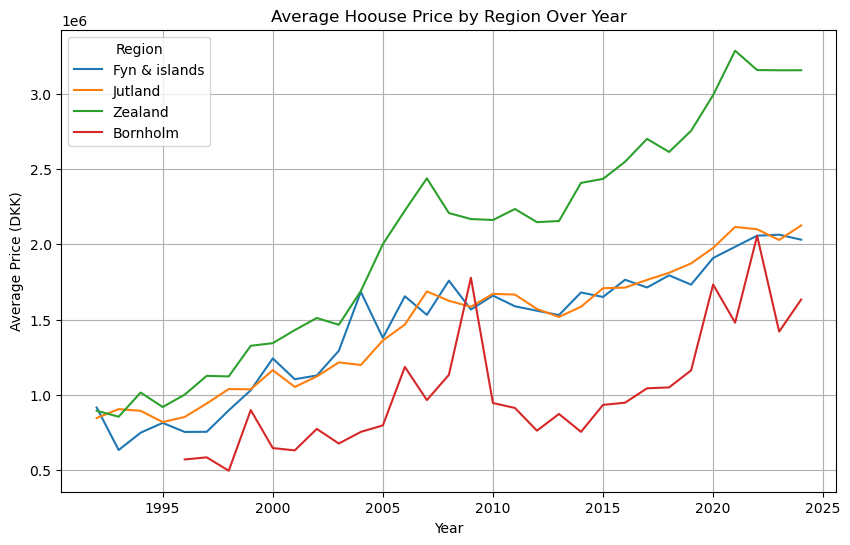

In [ ]:
# Group by year and region
avg_by_year_region = data.groupby(['year','region'])['purchase_price'].mean().reset_index()

# Display by plot
plt.figure(figsize = (10, 6))
sns.lineplot(data = avg_by_year_region, x = 'year', y = 'purchase_price', hue = 'region', palette = 'tab10')
plt.title("Average Hoouse Price by Region Over Year")
plt.xlabel("Year")
plt.ylabel("Average Price (DKK)")
plt.legend(title = 'Region')
plt.grid(True)
plt.show()


There are clear regional differences in house prices across Denmark. Zealand stands out as the most expensive region, with significantly higher average house prices compared to other parts of the country. This is largely driven by the presence of Copenhagen, Denmark's capital and economic hub, as well as affluent coastal towns like Hellerup, Charlottenlund, and Vedbæk. These areas are known for their scenic waterfronts, high quality of life, and strong demand — all of which contribute to elevated property values.

In contrast, regions such as Jutland, Fyn, and Bornholm have lower average prices, offering more affordable housing options

Check the distribution of numerical features

In [ ]:
list(set(data.dtypes.tolist()))

[dtype('<M8[ns]'),
 dtype('float64'),
 dtype('int32'),
 dtype('O'),
 dtype('int64')]

In [ ]:
data_num = data.select_dtypes(include = ['float64', 'int64'])
data_num.head()

,house_id,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,zip_code,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%,room_density,house_age
0,16,1997,6500000,-3.0,5,142.0,45774.647887,2680,3.1,1.927025,4.107445,0.035211,27
1,13,1885,3400000,0.0,2,46.0,73913.043478,1973,3.1,1.927025,4.107445,0.043478,139
2,60,1949,4550000,-4.0,4,112.0,40625.000000,2680,3.1,1.927025,4.107445,0.035714,75
3,29,2001,1630000,-12.0,4,186.0,8763.440860,4400,3.1,1.927025,4.107445,0.021505,23
4,92,1965,1975000,-10.0,3,82.0,24085.365854,3520,3.1,1.927025,4.107445,0.036585,59


Plot the distribution for all numerical features

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'house_id'}>,
        <Axes: title={'center': 'year_build'}>,
        <Axes: title={'center': 'purchase_price'}>],
       [<Axes: title={'center': '%_change_between_offer_and_purchase'}>,
        <Axes: title={'center': 'no_rooms'}>,
        <Axes: title={'center': 'sqm'}>,
        <Axes: title={'center': 'sqm_price'}>],
       [<Axes: title={'center': 'zip_code'}>,
        <Axes: title={'center': 'nom_interest_rate%'}>,
        <Axes: title={'center': 'dk_ann_infl_rate%'}>,
        <Axes: title={'center': 'yield_on_mortgage_credit_bonds%'}>],
       [<Axes: title={'center': 'room_density'}>,
        <Axes: title={'center': 'house_age'}>,
        <Axes: title={'center': 'year'}>, <Axes: >]], dtype=object)

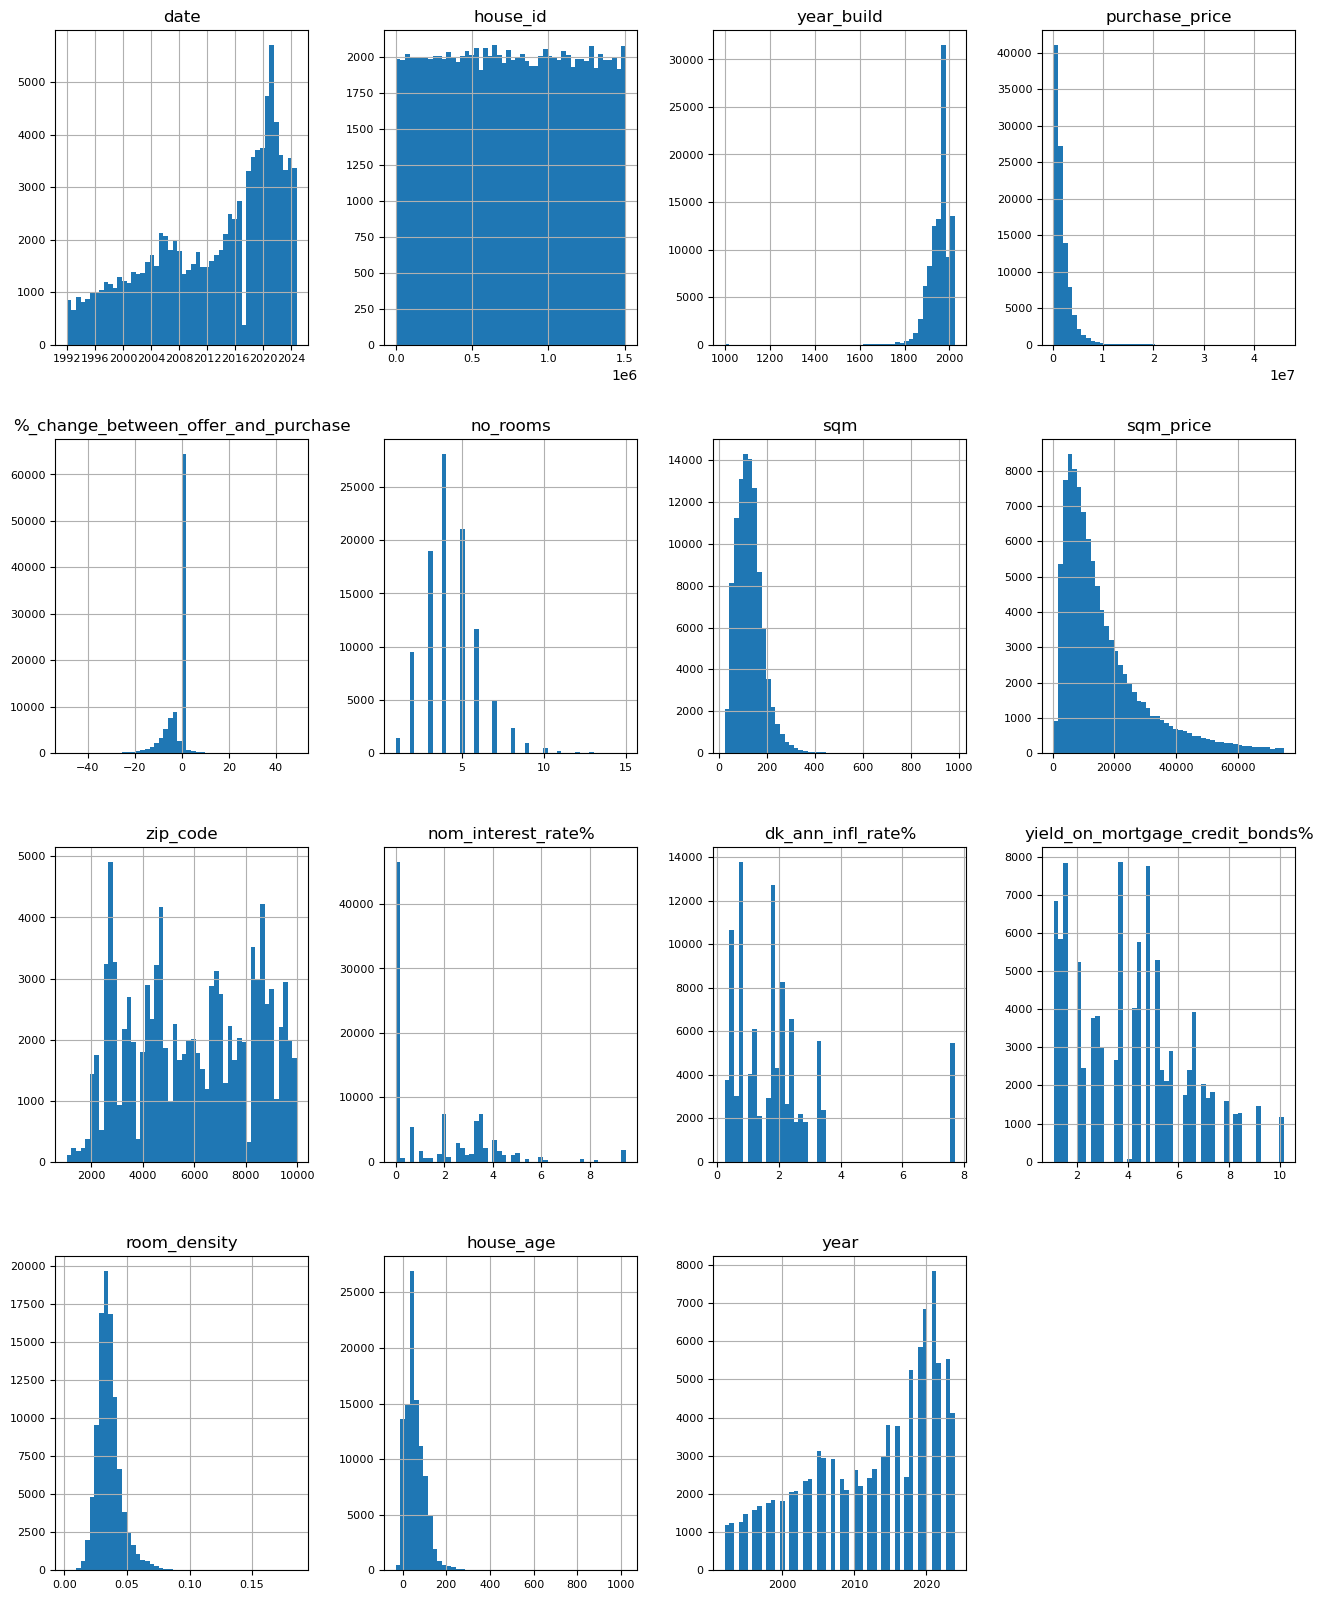

In [ ]:
data.hist(figsize = (16, 20), bins = 50, xlabelsize=8, ylabelsize=8)

After reviewing the feature plots and performing exploratory analysis, we identified several potential factors influencing Danish house prices. To quantitatively assess their impact, we employed the XGBoost regression model, which is well-suited for tabular data and provides robust feature importance scores.

Based on the model's output, we can clearly identify which features—such as region, house type, living area (sqm), house age, and number of rooms—have the most significant influence on predicting housing prices in Denmark.

Preprocess Data:

In [ ]:
# Define feature and target
features = ['house_type', 'region', 'house_age', 'no_rooms', 'sqm']
target = 'purchase_price'

feature_data = data[features]


# Since 'region' and 'house_type' are categorical strings, use One-Hot Encoding to encode them
encoded_data = pd.get_dummies(feature_data, columns=['region', 'house_type'], drop_first = True)


# Since we are using XGBoost, we can skip the process of normalizing data

X = encoded_data
y = data[target]


Perform a train-test split and train model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = xg.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Check the model accuracy
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:,.0f}")
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.0f} DKK")

MSE: 2,311,555,255,588
RMSE: 1,520,380 DKK


The accuracy of the model is acceptable for a house price model.
The next step is to obtain the most important features from the XGBoost model.

In [ ]:
# Get feature importances
importance_values = model.feature_importances_
feature_names = X.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_values}).sort_values(by='importance', ascending=False)

print(importance_df.head(10))

                  feature  importance
5          region_Zealand    0.308962
7  house_type_Summerhouse    0.186194
9        house_type_Villa    0.142336
2                     sqm    0.103708
8    house_type_Townhouse    0.073745
6         house_type_Farm    0.053341
0               house_age    0.047902
3    region_Fyn & islands    0.037825
1                no_rooms    0.026237
4          region_Jutland    0.019750


/var/folders/h8/bg6dvzlx5l54hq8j9yf79xqc0000gn/T/ipykernel_16474/3493807263.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='importance', y='feature', palette='viridis')


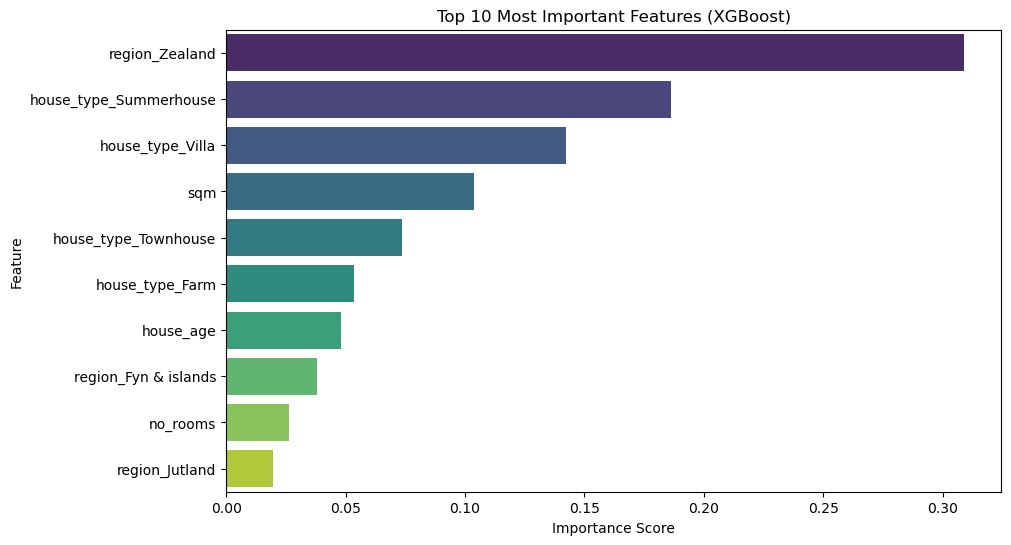

In [ ]:
# Plot the feature importance

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature', palette='viridis')
plt.title("Top 10 Most Important Features (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

We successfully get the top 10 most important features from XGBoost model for Denmark's house prices:

1. region_Zealand
2. house_type_Summerhouse
3. house_type_Villa
4. sqm
5. house_type_Townhouse
6. house_type_Farm
7. house_age
8. region_Fyn&island
9. no_rooms
10. region_Jutland
    
Next, I will use the Random Forest model and compare the result with XGBoost.

RMSE: 1612514.09


/var/folders/h8/bg6dvzlx5l54hq8j9yf79xqc0000gn/T/ipykernel_16474/86438237.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = rf_importance_df.head(10), x ='importance', y='feature', palette='viridis')


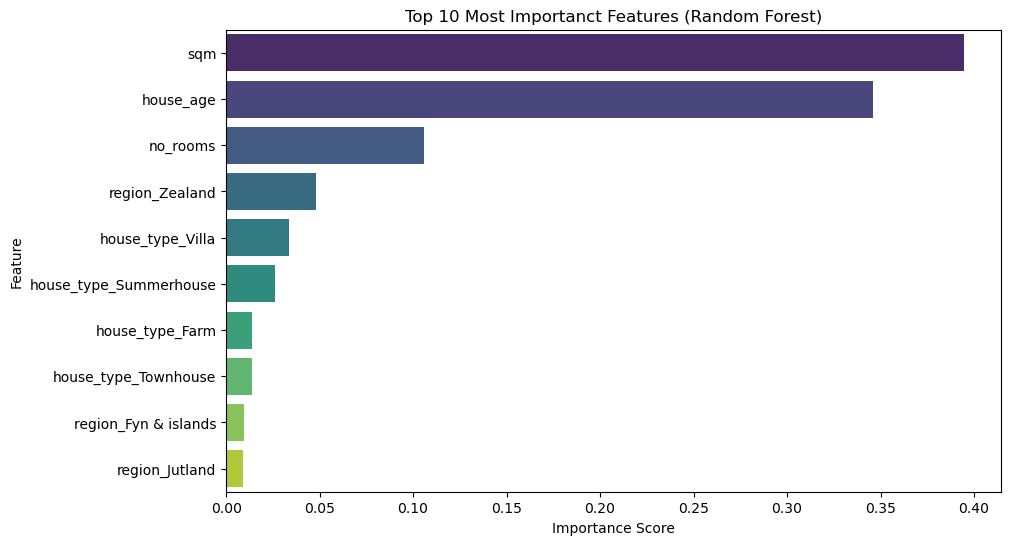

In [ ]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) 

# Predict on the dataset
rf_y_pred = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, rf_y_pred)
rmse_rf = np.sqrt(mse_rf)

print(f"RMSE: {rmse_rf:.2f}")


# Get Random Forest importances
rf_importances = rf_model.feature_importances_
rf_feature_names = X.columns

# Create DataFrame
rf_importance_df = pd.DataFrame({
    'feature':rf_feature_names,
    'importance':rf_importances}).sort_values(by ='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data = rf_importance_df.head(10), x ='importance', y='feature', palette='viridis')
plt.title("Top 10 Most Importanct Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

    


The Random Forest model has a similar accuracy to the XGBoost model.
The Top 10 feature importance from the Random Forest model:
1. sqm
2. house_age
3. no_rooms
4. region_Zealand
5. house_type_Villa
6. house_type_Summerhouse
7. house_type_Farm
8. house_type_Townhouse
9. house_type&island
10. region_Jutland

Both XGBoost and Random Forest models confirm that sqm(property size), location(region_Zealand), and house_type(Villa, Summerhouse) have the most significant impact on Danish house prices. This aligns with expectations that larger homes in desirable regions with premium property types tend to command higher prices.







